In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [8]:
import keras
from keras import layers
from keras import ops
import tensorflow as tf

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Test keras version and cuda installation
for each in tf.config.list_physical_devices():
    print(each)
    
print("Current tensorflow ->", tf.__version__)
print("Current keras ->", keras.__version__)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Current tensorflow -> 2.16.2
Current keras -> 3.4.1.dev2024070803


In [11]:
# data preparation

num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [13]:
# hyperparameters configuration
learning_rate = 0.001
weight_decay = 0.0001

batch_size = 256
num_epochs = 10  # actual training with 100, 10 for test

image_size = 72  # target image size regards preprocessing
patch_size = 6   # image size of each patched content
num_patches = (image_size // patch_size) **2   #

projection_dim = 64
num_heads = 4

transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # size of transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024
]   # size of the dense layers of the final head (classification)

In [14]:
# Data augmentation

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [15]:
# MLP
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [16]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

2024-07-09 21:19:50.627254: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
E0000 00:00:1720531190.684549   14562 asm_compiler.cc:126] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108
12


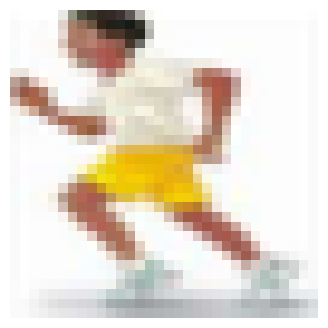

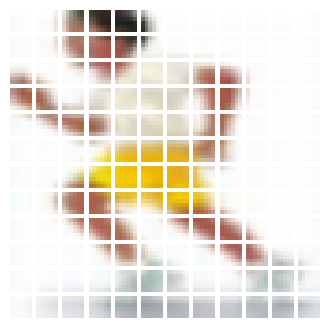

In [17]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")


resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), 
    size=(image_size, image_size)
)

resized_image = tf.cast(resized_image, dtype=tf.float32)


patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
print(n)
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    # print(i, patch.shape)
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))  # each small patch -> 108, 108->(6,6,3)
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [18]:
# implement patch encoding layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        """
        patches -> {
                      patch_0 {dim0, dim1, ... dim_m}
                      patch_1 {dim0, dim1, ... dim_m}
                      ...
                      patch_n {dim0, dim1, ... dim_m}
        }
        Thus, m*n -> num_patches*projection_dim
        """
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim = num_patches, 
            output_dim=projection_dim,
        )
    
    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(
                start=0,
                stop=self.num_patches,
                step=1
            ),
            axis=0,
        )
        projected_patches = self.projection(patch)
        encoded= projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        

In [19]:
# build vit

def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(
        num_patches,
        projection_dim
    )(patches)
    
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads = num_heads,
            key_dim = projection_dim,
            dropout=0.1,
        )(x1, x1) # for self-attention,key and value often same
        # skip connection, residual block
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(
            x3, 
            hidden_units=transformer_units,
            dropout_rate=0.1,
        )
        encoded_patches = layers.Add()([x3, x2])
        
    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
# compile, train, and eval

def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate = learning_rate, 
        weight_decay=weight_decay,
    )
    
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(
            from_logits=True,
        ),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5,name="top-5-accuracy"),
        ],
    )
    
    checkpoint_filepath="./ckpoint/vit-test-ckp.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )
    
    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    
    print(f"Test acc: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 acc: {round(top_5_accuracy * 100, 2)}%")
    
    return history

vit_classifier = create_vit_classifier()
history=run_experiment(vit_classifier)

def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_"+item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")

Epoch 1/10


E0000 00:00:1720531214.286376   14638 asm_compiler.cc:126] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-07-09 21:20:14.323064: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:190] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
E0000 00:00:1720531214.493359   14709 asm_compiler.cc:126] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

E0000 00:00:1720531214.494303   14705 asm_compiler.cc:126] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

E0000 00:00:1720531214.496657   14706 asm_compiler.cc:126] *** WARNING *** You are using

E0000 00:00:1720531215.602589   14638 asm_compiler.cc:126] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-07-09 21:20:15.619114: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:190] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
E0000 00:00:1720531215.778667   14758 asm_compiler.cc:126] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

E0000 00:00:1720531215.779453   14756 asm_compiler.cc:126] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

E0000 00:00:1720531215.779538   14760 asm_compiler.cc:126] *** WARNING *** You are using

176/176 ━━━━━━━━━━━━━━━━━━━━ 69s 275ms/step - accuracy: 0.0325 - loss: 4.8756 - top-5-accuracy: 0.1150 - val_accuracy: 0.1088 - val_loss: 3.9537 - val_top-5-accuracy: 0.3086
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 49s 278ms/step - accuracy: 0.0853 - loss: 4.0225 - top-5-accuracy: 0.2688 - val_accuracy: 0.1442 - val_loss: 3.5967 - val_top-5-accuracy: 0.3966
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 51s 288ms/step - accuracy: 0.1267 - loss: 3.7420 - top-5-accuracy: 0.3494 - val_accuracy: 0.1896 - val_loss: 3.3420 - val_top-5-accuracy: 0.4714
Epoch 4/10
173/176 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.1534 - loss: 3.5602 - top-5-accuracy: 0.4033